### Training loop stuff


In [ ]:
# | default_exp training
# | hide
import nbdev

nbdev.nbdev_export()
from nbdev.showdoc import *

In [ ]:
# | export
from tidygrad.tensor import Tensor
from tidygrad.utils import noop
import numpy as np

In [ ]:
import time

In [ ]:
# | export
def add_callbacks(func):
    # print("Adding callbacks", func.__name__)

    def decorator(self):
        full_name = func.__name__.replace("do_", "")
        pre_name = f"pre_{full_name}"
        post_name = f"post_{full_name}"

        start_time = time.time()
        for callback in self.callbacks:
            getattr(callback, pre_name, noop)(self)

        func(self)
        for callback in self.callbacks:
            getattr(callback, post_name, noop)(self)
        end_time = time.time()

        # if end_time - start_time > 0.5:
        #     print(f"{full_name} took {end_time - start_time:.2f} seconds")

    return decorator

In [ ]:
class Metric:
    def __init__(self, train=True, valid=True):
        self.train = train
        self.valid = valid

    @staticmethod
    def calc() -> float:
        raise NotImplementedError

class MultiClassAccuracy(Metric):
    name = "accuracy"

    @staticmethod
    def calc(learner) -> float:
        _, y = learner.batch
        return float((learner.preds.data.argmax(axis=-1) == y.data).mean())

class Loss(Metric):
    name = "loss"

    @staticmethod
    def calc(learner) -> float:
        return float(learner.loss.data)

In [ ]:
# | export

class DictLoggerCallback:
    val_loss = 0
    val_error = 0

    def __init__(self, metrics=None, history=None):
        self.metrics = [MultiClassAccuracy(), Loss()] if metrics is None else metrics
        self.history = [] if history is None else history

    def log(self, learner, metric, value, accum=False, step: int = None):
        if not hasattr(learner, "history"): learner.history = self.history
        if step is None:
            step = self.history[-1]["step"] + 1 if self.history else 0

        if not self.history or step != self.history[-1]["step"]:
            self.history.append({"step": step})

        if metric in self.history[-1] and accum:
            self.history[-1][metric] += value
        else:
            self.history[-1][metric] = value

    def post_calc_loss(self, learner):
        for m in self.metrics:
            if learner.training:
                if m.train: self.log(learner, f"{m.name}", m.calc(learner), accum=False, step=learner.step)
            else:
                if m.valid: self.log(learner, f"val_{m.name}", m.calc(learner), accum=True, step=learner.step)

    def post_all_batches(self, learner):
        for m in self.metrics:
            if f"val_{m.name}" in self.history[-1]:
                self.history[-1][f"val_{m.name}"] /= len(learner.dl)

In [ ]:
# | export

class Learner:
    # dataloaders - train, test
    # model - function that outputs a tensor that can be fed into a loss function
    # loss_func - function that takes in a tensor and outputs a scalar
    # optimizer - Optimizer object
    def __init__(self, dataloaders, model, loss_func, optimizer, callbacks=[]):
        self.dataloaders = dataloaders
        self.model = model
        self.loss_func = loss_func
        self.optimizer = optimizer
        self.callbacks = callbacks if callbacks else []

        # The state of the learner. These are updated during training by various do_ functions
        self.training = False  # True if training, False if val/test.
        self.epoch = 0  # current epoch, starts with 1 when you start trainig.
        self.step = 0  # current step, increases by 1 every (training) batch
        self.dl = None  # current dataloader, could be train or test or val
        self.batch = None  # The current batch as a tuple of (x, y)
        self.preds: Tensor = None  # Output of the model

    def fit(self, epochs, start_epoch=0, start_step=None):
        self.start_epoch = start_epoch
        self.n_epochs = epochs
        self.step = self.step if start_step is None else start_step
        self.epochs = range(self.start_epoch, self.start_epoch + self.n_epochs)
        self.do_fit()

    @add_callbacks
    def do_fit(self):
        for e in self.epochs:
            self.epoch = e
            self.do_epoch()

    @add_callbacks
    def do_epoch(self):
        self.training = True
        self.dl = self.dataloaders.train
        self.do_all_batches()
        self.dl = self.dataloaders.test
        self.training = False
        self.do_all_batches()

    @add_callbacks
    def do_all_batches(self):
        for batch in self.dl:
            if self.training: self.step += 1
            self.batch = batch
            self.do_batch_forward()
            self.do_calc_loss()
            if self.training: self.do_batch_backward()

    @add_callbacks
    def do_calc_loss(self):
        _, y = self.batch
        self.loss = self.loss_func(self.preds, y)

    @add_callbacks
    def do_batch_forward(self):
        x, _ = self.batch
        self.preds = self.model(x)

    @add_callbacks
    def do_batch_backward(self):
        self.loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

In [ ]:
#| export
from tqdm.auto import tqdm

In [ ]:
#| export
def one_hot_encode_batch(y, n_classes):
    batch_size = len(y)
    assert batch_size > 0
    assert n_classes > 0
    assert y.shape == (batch_size, )
    assert np.min(y) >= 0

    # Initialize a zero matrix of shape (batch_size, num_classes)
    one_hot_matrix = np.zeros((batch_size, n_classes))

    # Fill in the appropriate elements
    one_hot_matrix[np.arange(batch_size), y] = 1

    return Tensor(one_hot_matrix)

In [ ]:
#| export

def metrics_names_pretty(metrics):
    """
    Return an str with the names of the metrics, extended to at least 8 characters
    """

    pretty = [f"{name:<10}" for name in metrics]
    return " ".join(pretty)

def metrics_last_pretty(metrics, metrics_dict):
    """
    Return an str with the last values of the metrics,
    extended to match the length of the metric names, min 10 characters
    """
    out = []

    for name in metrics:
        max_len = max(len(name), 10)
        if name in metrics_dict:
            value = metrics_dict[name]

            if isinstance(value, (int, str)):
                value = str(value)
            elif isinstance(value, float):
                value = (f"{value:.6f}")
            else:
                value = " " * (max_len)

            if len(value) > max_len: value = value[:max_len - 2] + ".."

            out.append(value + " " * (max_len - len(value)))
        else:
            out.append(" " * max_len)

    return " ".join(out)

In [ ]:
#| export

def print_metrics_header(metrics):
    return "Ep  | " + metrics_names_pretty(metrics) + " | " + metrics_names_pretty([f"val_{m}" for m in metrics]) + "\n"

def print_metrics(learner, metrics):
    train_metrics = {k: v for k, v in learner.history[-1].items() if k in metrics}
    val_metrics = {f"val_{m}": learner.history[-1].get(f"val_{m}", None) for m in metrics}
    return " | ".join([
        f"{learner.epoch:<3}",
        metrics_last_pretty(metrics, train_metrics),
        metrics_last_pretty([f"val_{m}" for m in metrics], val_metrics),
    ]) + "\n"


In [ ]:
#| exporti
from IPython.display import HTML, display
from matplotlib import pyplot as plt

In [ ]:
#| exporti

def denoise(L, window_size=10):
    i = [i for i, _ in L]
    x = np.array([x for _, x in L])

    pad_size = window_size // 2
    data_padded = np.pad(x, pad_width=pad_size, mode='edge')
    xx = np.convolve(data_padded, np.ones(window_size) / window_size, mode='valid')

    return [(p, q) for p, q in zip(i, xx)]

def plot_metrics(learner, metrics, plot_skip=5, x_lim=None, plot_smooth_training=0):
    if x_lim is None:
        x_lim = len(learner.dataloaders.train) * learner.n_epochs
    fig, ax = plt.subplots(1, len(metrics), figsize=(4 * len(metrics), 4), tight_layout=True)
    plt.close(fig)
    for i, m in enumerate(metrics):
        train_metrics = []
        val_metrics = []
        if x_lim > len(train_metrics):
            ax[i].set_xlim(right=x_lim)
        ax[i].set_title(m)
        if not hasattr(learner, "history"): continue
        for idx, data in enumerate(learner.history):
            if m in data:
                train_metrics.append((idx, data[m]))
            if f"val_{m}" in data:
                val_metrics.append((idx, data[f"val_{m}"]))

        if plot_smooth_training > 0:
            smooth_train_metrics = denoise(train_metrics, plot_smooth_training)
            lines = ax[i].plot(*zip(*smooth_train_metrics), label=f"Train {m}")
            ax[i].plot(*zip(*train_metrics), color=lines[0].get_color(), alpha=0.3)
        else:
            ax[i].plot(*zip(*train_metrics), label=f"Train {m}")
        ax[i].plot(*zip(*val_metrics), label=f"Val {m}")
        if plot_skip > 0:
            _train_metrics = train_metrics[plot_skip:]

            if _train_metrics and val_metrics:
                y_min = min(min(y for _, y in _train_metrics), min(y for _, y in val_metrics))
                y_max = max(max(y for _, y in _train_metrics), max(y for _, y in val_metrics))
                ax[i].set_ylim([y_min, y_max])
        ax[i].legend()

    return fig

In [ ]:
#| export
class ProgressBarCallback:
    def __init__(
        self,
        metrics=["loss"],  # metrics to display, must be in the `learner.history`` dict
        plot=True,  # plot the metrics
        plot_train_skip_ylim=10,  # skip the first N training metrics when calculating the ylim
        plot_smooth_training=0  # smooth the training metrics with a moving average of N
    ) -> None:
        self.metrics = metrics
        self.plot = plot
        self.plot_skip = plot_train_skip_ylim
        self.plot_smooth_trainig = plot_smooth_training
        self.plot_handle = None
        self.stats_handle = None

    def pre_fit(self, learner: Learner):
        self.mbar = tqdm(initial=learner.start_epoch, total=learner.start_epoch + learner.n_epochs, desc="Epoch")
        self.pbar = tqdm(leave=False, bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}, {rate_fmt}]{postfix}")
        if self.plot:
            self.plot_handle = display(
                plot_metrics(
                    learner,
                    self.metrics,
                    plot_skip=self.plot_skip,
                    x_lim=learner.n_epochs * len(learner.dataloaders.train),
                ), display_id=True
            )
        self.stats = print_metrics_header(self.metrics)
        self.stats_handle = display(HTML("<b><pre>" + self.stats + "</pre></b>"), display_id=True)

    def post_epoch(self, learner):
        self.mbar.update(1)
        self.stats += print_metrics(learner, self.metrics)
        self.stats_handle.update(HTML("<b><pre>" + self.stats + "</pre></b>"))

        self.mbar.refresh()
        self.pbar.refresh()

    def pre_all_batches(self, learner):
        self.pbar.reset(total=len(learner.dl))
        if learner.training:
            self.pbar.set_description_str(f"{learner.epoch:<3}: Train")
        else:
            self.pbar.set_description_str(f"{learner.epoch:<3}: Valid")

    def post_all_batches(self, learner):
        if self.plot:
            self.plot_handle.update(
                plot_metrics(
                    learner,
                    self.metrics,
                    plot_skip=self.plot_skip,
                    x_lim=learner.n_epochs * len(learner.dataloaders.train),
                    plot_smooth_training=self.plot_smooth_trainig
                )
            )

    def post_calc_loss(self, learner):
        self.pbar.update(1)
        hist = learner.history[-1]
        metrics = [f"{k}={v:.4f}" for k, v in hist.items() if k in self.metrics]
        if not learner.training:
            val_metrics = {f"val_{m}": hist[f"val_{m}"] for m in self.metrics if f"val_{m}" in hist}
            metrics += [f"{k}={v:.4f}" for k, v in reversed(val_metrics.items())]

        self.pbar.set_postfix_str(" ".join(metrics), refresh=False)

In [ ]:
from tidygrad.utils.data import DataLoader, DataLoaders
from tidygrad.utils.datasets import MNIST, mnist_batch_tfm
from tidygrad.functional import sigmoid, relu, BCE_loss, CrossEntropy_loss
from tidygrad.optim import Adam
from functools import partial

In [ ]:
BS = 1024

mnist_train = DataLoader(MNIST(fashion=True), batch_size=BS, shuffle=True, batch_tfms=[mnist_batch_tfm])
mnist_test = DataLoader(MNIST(train=False, fashion=True), batch_size=BS, shuffle=False, batch_tfms=[mnist_batch_tfm])
INT_DIM = 128

w1 = Tensor(np.random.randn(784, INT_DIM) * 0.1, "w1")
b1 = Tensor(np.ones((1, INT_DIM)) * 0.1, "b1")
w2 = Tensor(np.random.randn(INT_DIM, 10) * 0.1, "w2")
# b2 = Tensor(np.zeros((1, 10)), "b2")

def linear_model(inputs, params, debug=list()):
    inputs.data = inputs.data.reshape(inputs.data.shape[0], -1)
    x = inputs
    w1, b1, w2 = params
    z1 = relu(x.mmul(w1, "z1") + b1)
    z2 = z1.mmul(w2, "z2")

    return z2

MM_func = partial(linear_model, params=[w1, b1, w2])
optimizer = Adam([w1, b1, w2], lr=0.005)

loss_f = lambda preds, targets: CrossEntropy_loss(preds, one_hot_encode_batch(targets.data, n_classes=10))
# loss_f = lambda preds, targets: CrossEntropy_loss(preds, one_hot_encode_batch(targets.data, 10))

student = Learner(
    dataloaders=DataLoaders(mnist_train, mnist_test),
    model=MM_func,
    loss_func=loss_f,
    optimizer=optimizer,
    callbacks=[DictLoggerCallback(), ProgressBarCallback(metrics=[
        "loss",
        "accuracy",
    ], plot_train_skip_ylim=15, plot_smooth_training=5)],
)

Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

|          | 0/? [00:00<?, ?it/s]

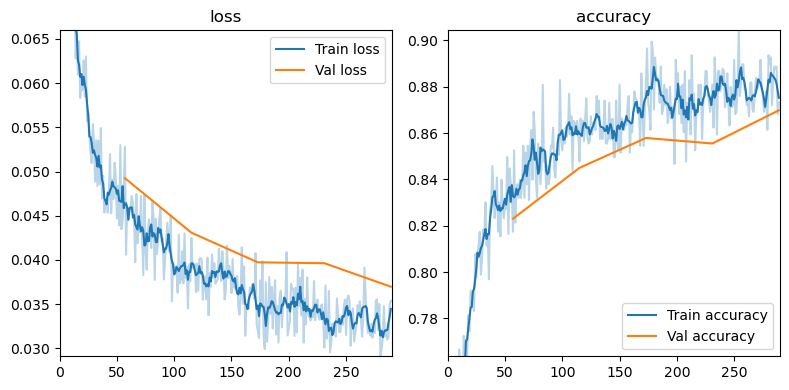

In [ ]:
#| eval: false
student.fit(epochs=5)